In [174]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as sim
import scipy.ndimage as sim


import mltools.utils.cuda_tools as cuda_tools
from mltools.networks import networks

device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import models
import importlib
importlib.reload(utils)

plt.rcParams.update({'font.size': 18})

memory_available [25929]
best GPU: 0


In [250]:
cfgs=[0.0,0.5,1.0,1.5,2.0,3.0,5.0,7.0]
suffixes=["_w_cfg_0.0","_w_cfg_0.5","_w_cfg_1.0","_w_cfg_1.5","_w_cfg_2.0","_w_cfg_3.0","_w_cfg_5.0","_w_cfg_7.0"]
seeds=[0,100,200,300,400]   
plot_datass={}
c=0
sep_cols={}
for cfg,suffix in zip(cfgs,suffixes):
    for seed in seeds:
        for fol in glob.glob(f"../data/images_1/2x2_final2/col_sweep_cfg_long2/*/seed={seed}"):
            parentfolname=os.path.basename(os.path.dirname(fol))
            sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
            sep_cols[sep_col]=1
            sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
            plot_data_file=os.path.join(fol,f"plot_data{suffix}.pth")
            plot_data=torch.load(plot_data_file)
            plot_data["seed"]=seed
            plot_data["sep_col"]=sep_col
            plot_data["sep_size"]=sep_size
            plot_datass.setdefault((sep_col,sep_size,str(cfg)),[]).append(plot_data)
            c+=1
len(plot_datass),c

(72, 360)

In [251]:
sep_cols.keys()

dict_keys(['0.432', '0.321', '0.1', '0.579', '0.726', '0.8', '0.137', '0.247', '0.174'])

In [252]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
save_steps=plot_datas[0]["save_steps"]
save_steps[i_step_min]

50

In [253]:
cmap="gnuplot"
cmap="rainbow"
norm_col = mcolors.Normalize(vmin=0.1, vmax=0.8)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm_col(float(sep_col)))
norm_cfg = mcolors.Normalize(vmin=0.0, vmax=7.0)
def cfg_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm_cfg(float(sep_col)))

In [254]:
#sel=["0.1","0.174","0.247","0.321","0.395","0.468","0.542","0.616","0.689","0.763","0.8"]
sel=["0.137","0.247","0.395","0.542","0.689","0.8"]
sel=["0.247"]
sel=["0.1"]
sel=["0.137"]
#sel=["0.1"]
#sel=["0.8"]

star step 5334


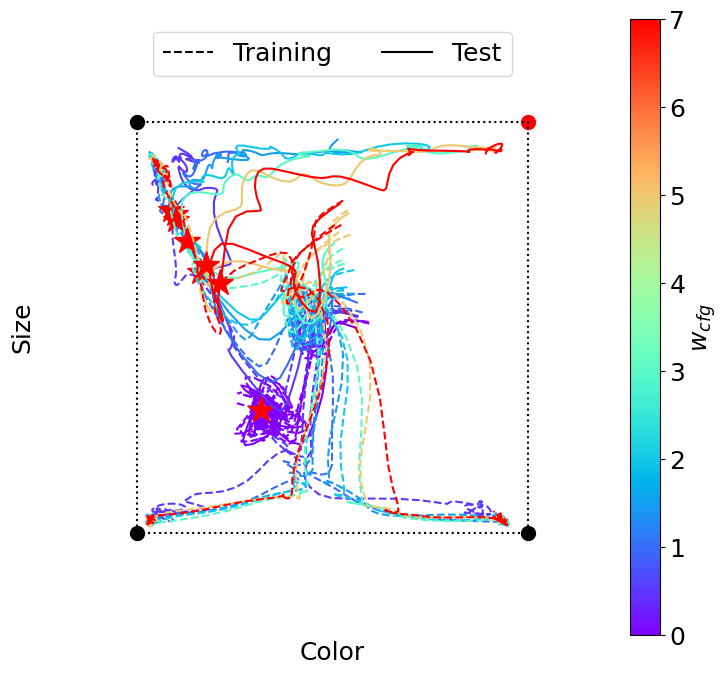

In [255]:
plt.figure(figsize=(8,8))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)

plot_star=True
i_star=33
print("star step",save_steps[i_star])
plot_singles=False
plot_mean=True
single_seeds=[0]

trajs_trss=[]
trajs_tess=[]
sep_cols=[]
sep_sizes=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_size=key[1]
    cfg=float(key[2])
    sep_cols.append(float(sep_col))
    sep_sizes.append(float(sep_size))
    if sep_col not in sel:
        #print("skipping",sep_col)
        continue
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    seeds=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
        seeds.append(plot_data["seed"])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    #color=sep_col_to_color(sep_col,cmap=cmap)
    color=cfg_to_color(cfg,cmap=cmap)

    if plot_mean:
        plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],c=color,markersize=5)
        for i in range(3):
            plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
        if plot_star:
            plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
            for i in range(3):
                pass
                #plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)

    if plot_singles:
        for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
            seed=seeds[i_seed]
            if seed not in single_seeds:
                continue
            traj_smooth=sim.gaussian_filter1d(traj_te_single,2.0,axis=0,truncate=6.0)
            plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
            plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        for i in range(3):
            for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                seed=seeds[i_seed]
                if seed not in single_seeds:
                    continue
                traj_smooth=sim.gaussian_filter1d(traj_tr_single,2.0,axis=0,truncate=6.0)
                plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
                #plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        if plot_star:
            for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
                seed=seeds[i_seed]
                if seed not in single_seeds:
                    continue
                traj_smooth=sim.gaussian_filter1d(traj_te_single,2.0,axis=0,truncate=6.0)
                plt.plot(traj_smooth[i_star,0],traj_smooth[i_star,1],marker="*",c="r",markersize=20)
            for i in range(3):
                for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                    seed=seeds[i_seed]
                    if seed not in single_seeds:
                        continue
                    traj_smooth=sim.gaussian_filter1d(traj_tr_single,2.0,axis=0,truncate=6.0)
                    #plt.plot(traj_smooth[i_star,0],traj_smooth[i_star,1],marker="*",c="r",markersize=20)

trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
sep_cols=np.array(sep_cols)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_cfg)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$w_{cfg}$")

skipping 0.432
skipping 0.321
skipping 0.1
skipping 0.579
skipping 0.726
skipping 0.8
skipping 0.247
skipping 0.174
skipping 0.432
skipping 0.321
skipping 0.1
skipping 0.579
skipping 0.726
skipping 0.8
skipping 0.247
skipping 0.174


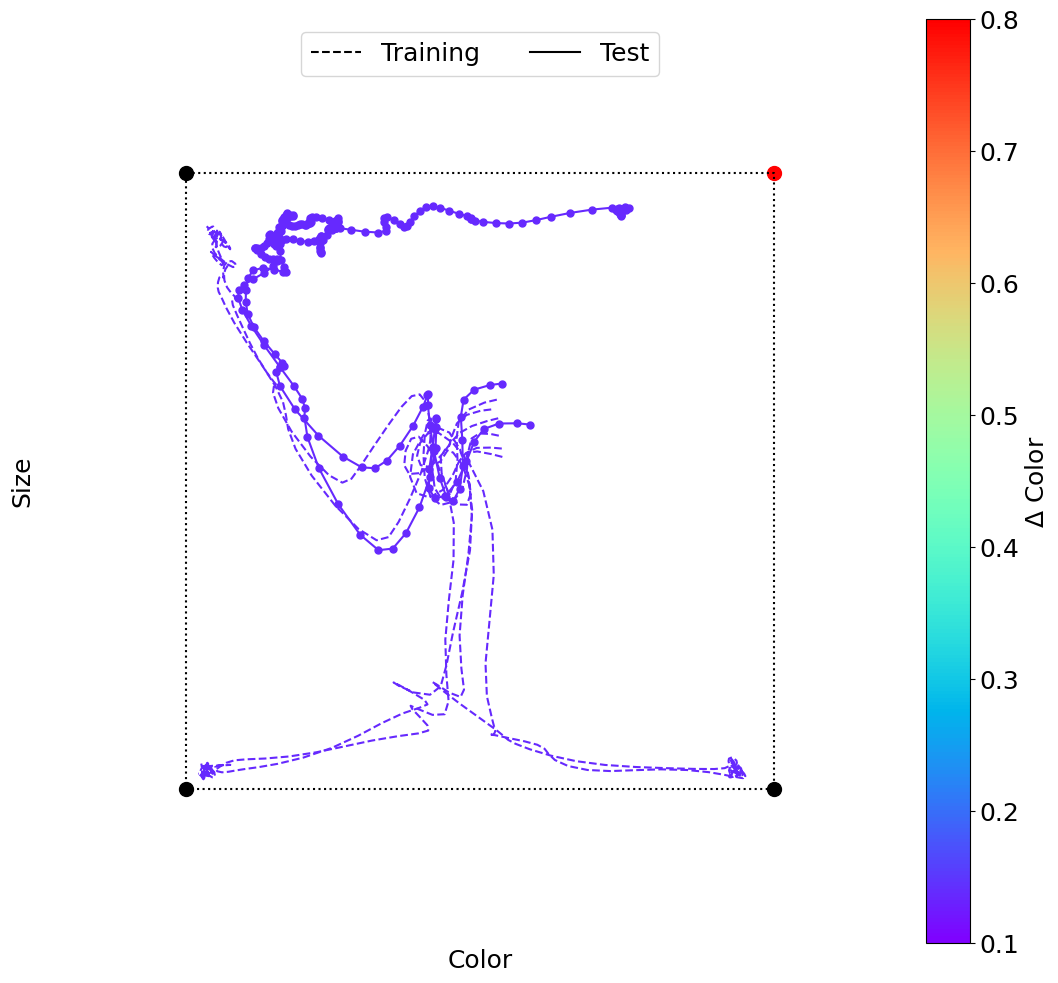

In [28]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)

plot_star=False
plot_singles=False
plot_mean=True
single_seeds=[0,100,200,300,400]

trajs_trss=[]
trajs_tess=[]
sep_cols=[]
sep_sizes=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_size=key[1]
    cfg=float(key[2])
    sep_cols.append(float(sep_col))
    sep_sizes.append(float(sep_size))
    if sep_col not in sel:
        print("skipping",sep_col)
        continue
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    seeds=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
        seeds.append(plot_data["seed"])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    color=sep_col_to_color(sep_col,cmap=cmap)

    if plot_mean:
        plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],c=color,markersize=5)
        for i in range(3):
            plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)

    if plot_singles:
        for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
            seed=seeds[i_seed]
            if seed not in single_seeds:
                continue
            traj_smooth=sim.gaussian_filter1d(traj_te_single,2.0,axis=0,truncate=6.0)
            plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
            plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        for i in range(3):
            for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                seed=seeds[i_seed]
                if seed not in single_seeds:
                    continue
                traj_smooth=sim.gaussian_filter1d(traj_tr_single,2.0,axis=0,truncate=6.0)
                plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
                #plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
    if plot_star:
        print("star step",save_steps[i_star])
        i_star=20
        plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
        for i in range(3):
            plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)

trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
sep_cols=np.array(sep_cols)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

"""
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
images=[]
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    images.append(image)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)
images=np.stack(images,axis=0)
"""

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Color")
#plt.savefig("../figures/final/training_dynamics_sep_col_wd=0.05.png")